# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
import warnings
warnings.filterwarnings('ignore')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM B lineage

In [4]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig3a_bcell_dr_20210115.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 28583 × 33712 
    obs: 'cell.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'processing.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'april_cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_20200718', 'nk_meta', 'mito.threshold', 'S_score', 'G2M_score', 'phase', 'phase_combined', 'S/G2M_score_combined'
    var: 'gene_ids-1', 'feature_types-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell.labels_colors', 'draw_graph', 'neighbors', 'orig.ident_colors', 'pca', 'phase_combined_colors', 'sequencing.type_colors'
    obsm: 'X_draw_graph_fa', 'X_orig_pca', 'X_pca', 'X_umap'
    varm: 'PCs'

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
pre pro B progenitor     5427
pro B progenitor         5528
pre B progenitor        14229
immature B cell          1988
naive B cell             1411
dtype: int64

# Assign cells as either "cycling" or "not cycling" based on whether their cell cycle score cutoff is above or below the mean

In [7]:
adata.obs["S/G2M_score_combined"].mean()

0.12705286

In [8]:
a = pd.DataFrame(adata.obs["S/G2M_score_combined"])

adata.obs["bcell_state"] = pd.cut(a["S/G2M_score_combined"],
                 [-1, 0.127, np.inf],
                 labels=['not_cycling','cycling'])

In [9]:
cell_numbers = adata.obs.groupby(["bcell_state"]).apply(len)
cell_numbers

bcell_state
not_cycling    17529
cycling        11054
dtype: int64

In [10]:
adata.obs["cell.labels_state"] = adata.obs["cell.labels"].astype(str) + '_' + adata.obs["bcell_state"].astype(str)

... storing 'cell.labels_state' as categorical


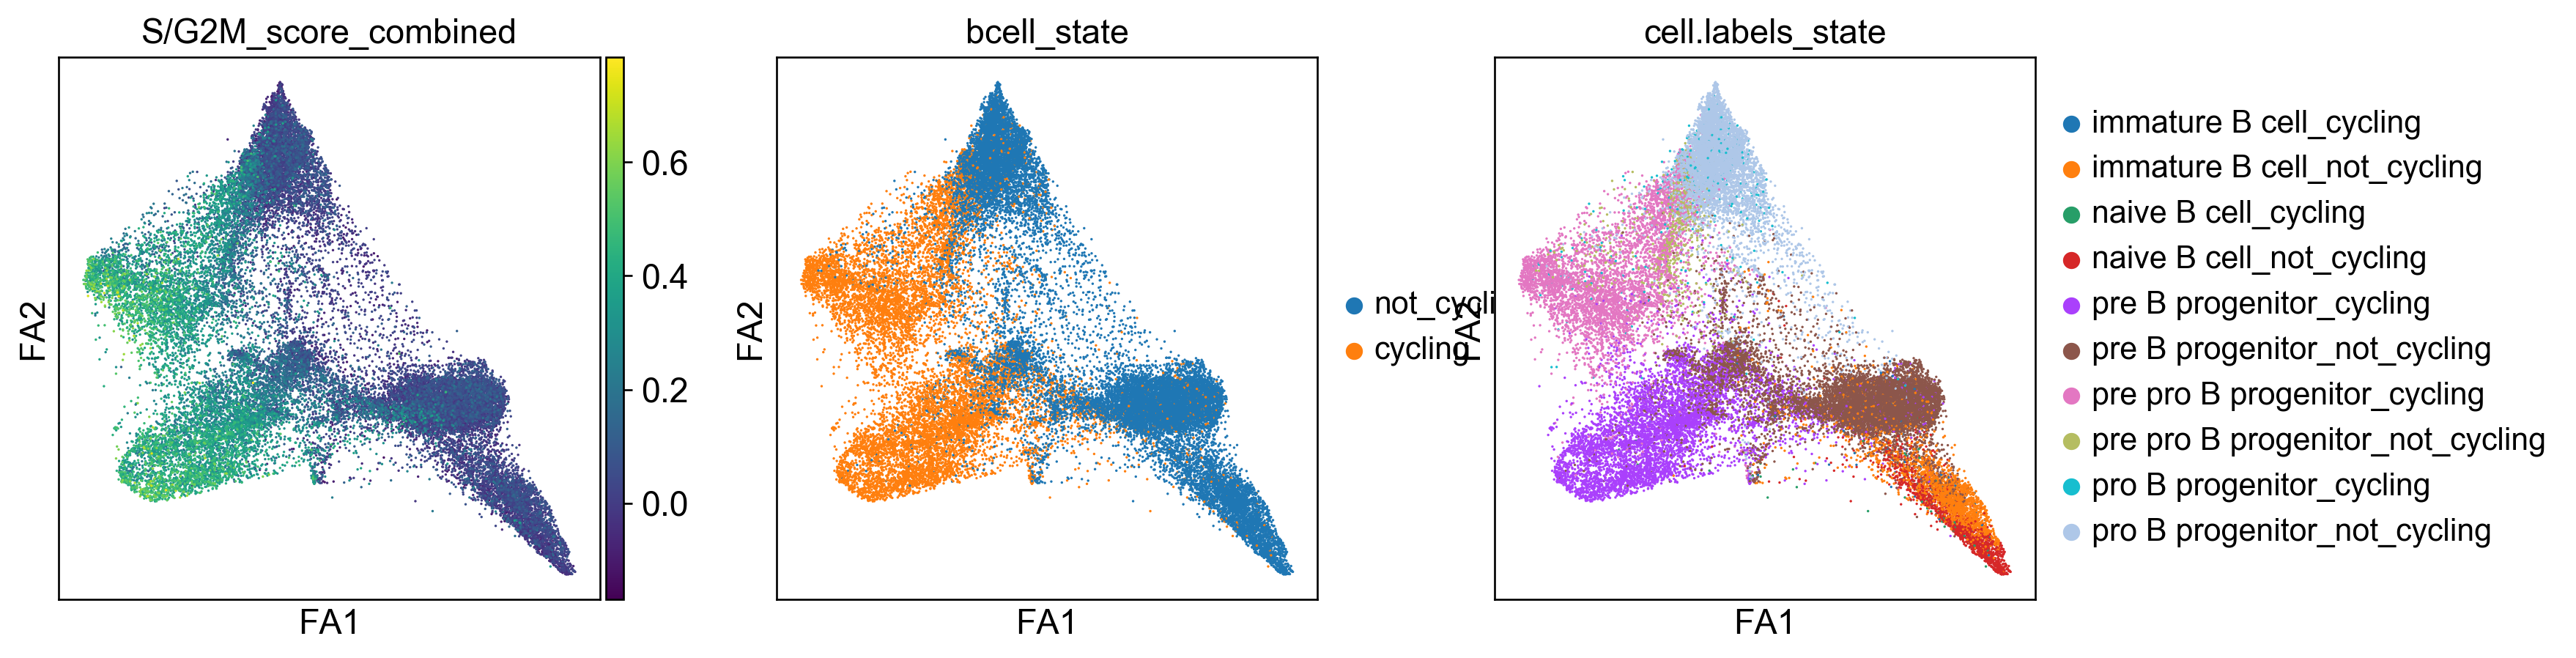

In [11]:
sc.pl.draw_graph(adata, color=['S/G2M_score_combined', 'bcell_state', 'cell.labels_state'], layout='fa') 

# Run DEGs between the negatively and positively selected Pre-B 

In [12]:
# run degs on normalised, logged and scaled data (saved as adata.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata, groupby='cell.labels_state', method='wilcoxon', use_raw=False, log_transformed=True, groups = ['pre B progenitor_cycling', 'pre B progenitor_not_cycling'])

In [13]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata, min_in_group_fraction=0.25, min_fold_change = 0.25, use_raw=False)

In [14]:
# save df for unfiltered degs
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/preb_state_20210115.csv")
degs_by_cluster[:10]

,pre B progenitor_cycling_names,pre B progenitor_cycling_logfold,pre B progenitor_cycling_pvals,pre B progenitor_cycling_pvals_a,pre B progenitor_not_cycling_names,pre B progenitor_not_cycling_logfold,pre B progenitor_not_cycling_pvals,pre B progenitor_not_cycling_pvals_a
0,NUSAP1,2.875224,0.0,0.0,ACSM3,3.587226,0.0,0.0
1,HMGB2,2.287256,0.0,0.0,IGHM,1.882326,0.0,0.0
2,TUBB,2.284116,0.0,0.0,PCDH9,1.883589,0.0,0.0
3,HIST1H4C,2.624992,0.0,0.0,CCDC112,2.527831,0.0,0.0
4,CDK1,2.649332,0.0,0.0,BTG1,1.558947,0.0,0.0
5,TUBA1B,2.175089,0.0,0.0,IRF4,2.187781,0.0,0.0
6,TOP2A,2.718374,0.0,0.0,RPS27,1.229684,0.0,0.0
7,PDLIM1,2.330717,0.0,0.0,NSMCE1,2.374387,0.0,0.0
8,MKI67,2.612144,0.0,0.0,YBX3,1.725246,0.0,0.0
9,STMN1,1.909304,0.0,0.0,CD81,1.775205,0.0,0.0


In [15]:
# save df for filtered degs
result = adata.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/preb_state_filtered_20210115.csv")
degs_by_cluster_filtered[:10]

,pre B progenitor_cycling_names,pre B progenitor_cycling_logfold,pre B progenitor_cycling_pvals,pre B progenitor_cycling_pvals_a,pre B progenitor_not_cycling_names,pre B progenitor_not_cycling_logfold,pre B progenitor_not_cycling_pvals,pre B progenitor_not_cycling_pvals_a
0,NUSAP1,2.875224,0.0,0.0,ACSM3,3.587226,0.0,0.0
1,HMGB2,2.287256,0.0,0.0,IGHM,1.882326,0.0,0.0
2,TUBB,2.284116,0.0,0.0,PCDH9,1.883589,0.0,0.0
3,HIST1H4C,2.624992,0.0,0.0,CCDC112,2.527831,0.0,0.0
4,CDK1,2.649332,0.0,0.0,BTG1,1.558947,0.0,0.0
5,TUBA1B,2.175089,0.0,0.0,IRF4,2.187781,0.0,0.0
6,TOP2A,2.718374,0.0,0.0,NaN,1.229684,0.0,0.0
7,PDLIM1,2.330717,0.0,0.0,NSMCE1,2.374387,0.0,0.0
8,MKI67,2.612144,0.0,0.0,YBX3,1.725246,0.0,0.0
9,STMN1,1.909304,0.0,0.0,CD81,1.775205,0.0,0.0


# Remove cycling genes and run DEGs between the negatively and positively selected Pre-B  

In [16]:
#Score cell cycle and visualize the effect:
# load file in
cc_genes_file = '/Users/b8058304/Documents/PhD_work/Coding/bm/resources_for_pipelines/cell_cycle_makosco.csv'
cc_genes = pd.read_csv(cc_genes_file, delimiter=',')
# removing na from s and g2m list
s_genes = cc_genes['S'].dropna().tolist()
g2m_genes = cc_genes['G2/M'].dropna().tolist()
g1_s_genes = cc_genes['G1/S'].dropna().tolist()
m_genes = cc_genes['M'].dropna().tolist()
m_g1_genes = cc_genes['M/G1'].dropna().tolist()
total_cc_genes_list = s_genes + g2m_genes + g1_s_genes + m_genes + m_g1_genes

y_genes = total_cc_genes_list
no_trail = []
for x in y_genes:
    y = x.strip()
    no_trail.append(y)
total_cc_genes_list = no_trail 

In [17]:
adata.shape

(28583, 33712)

In [18]:
non_cycle_genes_list = [name for name in adata.var_names if not name in total_cc_genes_list]
adata_no_cycle = adata[:, non_cycle_genes_list]

In [19]:
adata_no_cycle.shape

(28583, 33165)

In [20]:
# run degs on normalised, logged and scaled data (saved as adata_no_cycle.X).
# calculate degs using wilcoxon rank sum test with benjamini-hochberg correction. 
#based on ln transformed count data 
sc.tl.rank_genes_groups(adata_no_cycle, groupby='cell.labels_state', method='wilcoxon', use_raw=False, log_transformed=True, groups = ['pre B progenitor_cycling', 'pre B progenitor_not_cycling'])

Trying to set attribute `.uns` of view, copying.


In [21]:
# filter the degs for those which are expressed in at least 25% of cells in cluster. log2fc of the ln-transformed
# data will be shown.
sc.tl.filter_rank_genes_groups(adata_no_cycle, min_in_group_fraction=0.25, min_fold_change = 0.25, use_raw=False)

In [22]:
# save df for unfiltered degs
result = adata_no_cycle.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_by_cluster = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})

# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/preb_state_nocycle_20210115.csv")
degs_by_cluster[:10]

,pre B progenitor_cycling_names,pre B progenitor_cycling_logfold,pre B progenitor_cycling_pvals,pre B progenitor_cycling_pvals_a,pre B progenitor_not_cycling_names,pre B progenitor_not_cycling_logfold,pre B progenitor_not_cycling_pvals,pre B progenitor_not_cycling_pvals_a
0,TUBA1B,2.175089,0.0,0.0,ACSM3,3.587226,0.0,0.0
1,PDLIM1,2.330717,0.0,0.0,IGHM,1.882326,0.0,0.0
2,STMN1,1.909304,0.0,0.0,PCDH9,1.883589,0.0,0.0
3,HMGN2,1.916138,0.0,0.0,CCDC112,2.527831,0.0,0.0
4,H2AFZ,1.834368,0.0,0.0,BTG1,1.558947,0.0,0.0
5,H3F3A,2.272226,0.0,0.0,IRF4,2.187781,0.0,0.0
6,HMGB1,1.882613,0.0,0.0,RPS27,1.229684,0.0,0.0
7,SMC2,1.958464,0.0,0.0,NSMCE1,2.374387,0.0,0.0
8,DEK,1.790161,0.0,0.0,YBX3,1.725246,0.0,0.0
9,SPC25,2.737088,0.0,0.0,CD81,1.775205,0.0,0.0


In [23]:
# save df for filtered degs
result = adata_no_cycle.uns['rank_genes_groups_filtered']
groups = result['names'].dtype.names
degs_by_cluster_filtered = pd.DataFrame({group + '_' + key[:7]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals', 'pvals_adj']})
# the degs_by_cluster df shows the log2 fold change for each gene ordered by z-score underlying the computation 
# of a p-value for each gene for each group
degs_by_cluster_filtered.to_csv("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/figs/clustering_degs/preb_state_nocycle_filtered_20210115.csv")
degs_by_cluster_filtered[:10]

,pre B progenitor_cycling_names,pre B progenitor_cycling_logfold,pre B progenitor_cycling_pvals,pre B progenitor_cycling_pvals_a,pre B progenitor_not_cycling_names,pre B progenitor_not_cycling_logfold,pre B progenitor_not_cycling_pvals,pre B progenitor_not_cycling_pvals_a
0,TUBA1B,2.175089,0.0,0.0,ACSM3,3.587226,0.0,0.0
1,PDLIM1,2.330717,0.0,0.0,IGHM,1.882326,0.0,0.0
2,STMN1,1.909304,0.0,0.0,PCDH9,1.883589,0.0,0.0
3,HMGN2,1.916138,0.0,0.0,CCDC112,2.527831,0.0,0.0
4,H2AFZ,1.834368,0.0,0.0,BTG1,1.558947,0.0,0.0
5,H3F3A,2.272226,0.0,0.0,IRF4,2.187781,0.0,0.0
6,HMGB1,1.882613,0.0,0.0,NaN,1.229684,0.0,0.0
7,SMC2,1.958464,0.0,0.0,NSMCE1,2.374387,0.0,0.0
8,DEK,1.790161,0.0,0.0,YBX3,1.725246,0.0,0.0
9,SPC25,2.737088,0.0,0.0,CD81,1.775205,0.0,0.0


# Save the data

In [24]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig3a_bcell_dr_20210115.h5ad")

# Open the obj and run violin plots

In [25]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

In [26]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Import the FBM B cells

In [27]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs_mk2/data/fig3a_bcell_dr_20210115.h5ad")

# Run violin plots

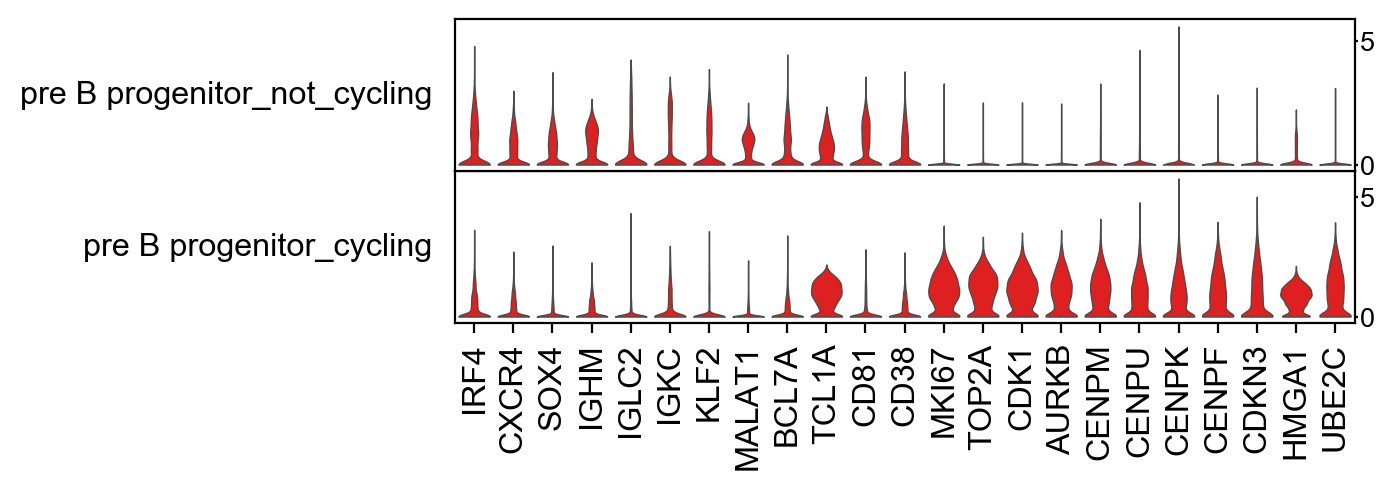

In [28]:
sc.settings.set_figure_params(dpi=100, dpi_save=1000)
subset = adata[adata.obs['cell.labels_state'].isin(['pre B progenitor_cycling', 'pre B progenitor_not_cycling'])].copy()
subset.obs["cell.labels_state"] = subset.obs["cell.labels_state"].cat.reorder_categories(
    ['pre B progenitor_not_cycling', 'pre B progenitor_cycling'])
genes = ["IRF4", "CXCR4", "SOX4", "IGHM", "IGLC2", "IGKC",  
         "KLF2",  "MALAT1",  "BCL7A", "TCL1A", "CD81",  "CD38",  
         "MKI67", "TOP2A", "CDK1", "AURKB", "CENPM", "CENPU", "CENPK", "CENPF",  
         "CDKN3", "HMGA1", "UBE2C"]

sc.pl.stacked_violin(subset, var_names=genes, save="pre_b_degs_pos_neg_20210115.pdf", rotation=90, 
                     groupby='cell.labels_state', use_raw=False, swap_axes=False, figsize=(6,2), 
                     row_palette=["#ff0000", "#ff0000", "#ff0000", "#0000ff", "#0000ff", "#0000ff"])